### Set Covering Problem

In the following notebook we try different approaches on how to solve the Set Cover Problem

In [1]:
from random import random
from functools import reduce
from collections import namedtuple
from queue import PriorityQueue

import numpy as np
import matplotlib.pyplot as plt

After generating some random subsets we check if the problem is feasible or not.

In [2]:
PROBLEM_SIZE = 20
NUM_SETS = 64
SETS = tuple(
    np.array([random() < 0.25 for _ in range(PROBLEM_SIZE)])
    for _ in range(NUM_SETS)
)

State = namedtuple('State', ['taken', 'not_taken'])

def goal_check(state):
    return np.all(reduce(
        np.logical_or,
        [SETS[i] for i in state.taken],
        np.array([False for _ in range(PROBLEM_SIZE)]),
    ))


assert goal_check(
    State(set(range(NUM_SETS)), set())
), "Problem not solvable"



We create a wrapper to explore the various algorithms

In [3]:
def search(priority):
    frontier = PriorityQueue()
    state = State(set(), set(range(NUM_SETS)))
    frontier.put((priority(state), state))

    counter = 0
    _, current_state = frontier.get()
    while not goal_check(current_state):
        counter += 1
        for action in current_state[1]:
            new_state = State(
                current_state.taken ^ {action},
                current_state.not_taken ^ {action},
            )
            frontier.put((priority(new_state), new_state))
        _, current_state = frontier.get()

    print(
        f"Solved in {counter:,} steps ({len(current_state.taken)} tiles)"
    )

    return current_state.taken

We can now define different priorities to impose which algorithm to follow:
<ul>
  <li><b>Breadth first:</b> The algorithm should prioritize more shallow nodes, exploring each one before going in depth</li> 
  <li><b>Greedy best first:</b> The algorithm should prioritize the "gain", that is, the number of uncovered tiles in each new action</li> 
  <li><b>A*:</b> The priority should be influenced by two parameters:
  <ul>
      <li><b>g(x):</b> Should be equal to the cost of each edge (unitary in this case)</li>
      <li><b>h(x):</b> It's an heuristic that represents how close we are to our goal, in this case it's represented by the number of uncovered tiles</li>
    </ul></li> 
</ul>

In [4]:
def breadth_first(state):
    return len(state.taken)

def greedy_best_first(state):
    return PROBLEM_SIZE - sum(
        reduce(
            np.logical_or,
            [SETS[i] for i in state.taken],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        ))

def a_star(state, general=breadth_first, heuristic=greedy_best_first):
    return general(state) + heuristic(state)

I also added a function to visualize the solution found by each algorithm, the black boxes represent taken tiles (ones) and the white ones represent non-taken tiles (zeroes), intuitively there should be at least one black box for each column.

In [5]:
def graph(solution, number=1, title=None):
    map = None
    for i in solution:
        if map is not None:
            map = np.vstack((map, SETS[i]))
        else:
            map = SETS[i]

    plt.figure(number)
    plt.imshow(map, cmap='binary')
    ax = plt.gca()
    ax.set_yticks(np.arange(len(solution)), solution)
    ax.get_xaxis().set_visible(False)
    if title is not None:
        plt.title(title)
    plt.show

We can now run the different algorithms and compare the solutions:

Solved in 316,885 steps (4 tiles)
Solved in 4 steps (4 tiles)
Solved in 4 steps (4 tiles)


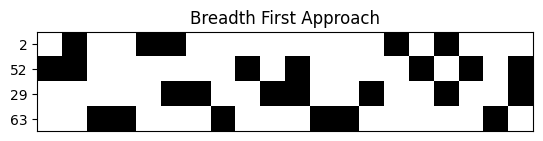

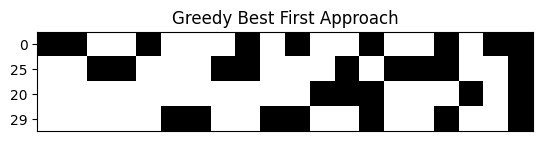

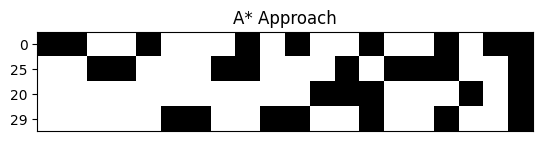

In [6]:
bf = search(breadth_first)
gbf = search(greedy_best_first)
a = search(a_star)

graph(bf, 1, 'Breadth First Approach')
graph(gbf, 2, 'Greedy Best First Approach')
graph(a, 3, 'A* Approach')

## Observations
With an unitary cost for each edge traversed the result of the greedy best first and A* algorithms reach similar solutions, this is likely due to the fact that the heuristic cost is out of scale in respect to the unitary cost of the arcs, we can try to rescale it into the range [0, 1]

In [7]:
def rescaled(state):
    return greedy_best_first(state)/PROBLEM_SIZE

def quadratic_rescaled(state):
    return greedy_best_first(state)**2/(PROBLEM_SIZE**2)

Let's try the newly defined heuristics and compare them with the old solutions, we expect the quadratic heuristic to penalize the distance more than the linear one, but perhaps the size of the problem we defined is too small to see the difference.

Solved in 254,081 steps (4 tiles)
Solved in 254,081 steps (4 tiles)


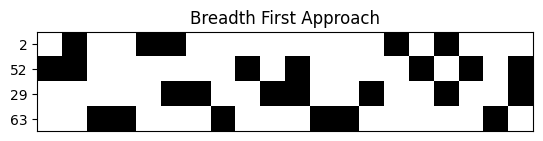

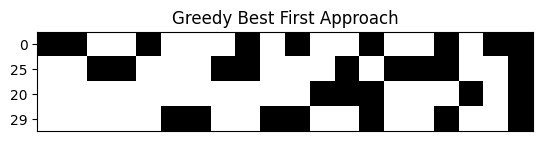

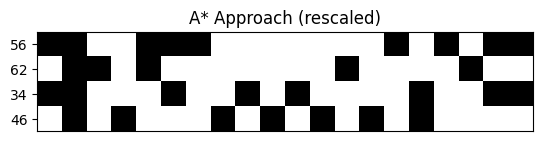

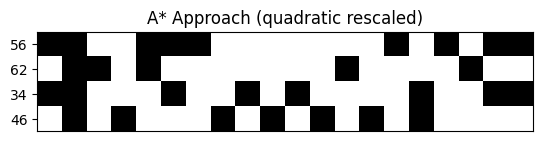

In [8]:
ra = search(lambda s : a_star(s, heuristic=rescaled))
qa = search(lambda s : a_star(s, heuristic=quadratic_rescaled))

graph(bf, 1, 'Breadth First Approach')
graph(gbf, 2, 'Greedy Best First Approach')
graph(ra, 3, 'A* Approach (rescaled)')
graph(qa, 4, 'A* Approach (quadratic rescaled)')

## References
[Giovanni Squillero for the original code](https://github.com/squillero/computational-intelligence)<br>